In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import sklearn

In [2]:
df = pd.read_csv('2012_public_use_data_aug2016.csv')
print(df.shape)
df.dtypes

(6720, 1119)


PUBID        int64
REGION       int64
CENDIV       int64
PBA          int64
FREESTN    float64
            ...   
DHCLBTU    float64
DHWTBTU    float64
DHCKBTU    float64
DHOTBTU    float64
PUBCLIM      int64
Length: 1119, dtype: object

In [3]:
df.sample(5)

,PUBID,REGION,CENDIV,PBA,FREESTN,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,...,FKCLBTU,FKWTBTU,FKCKBTU,FKOTBTU,DHHTBTU,DHCLBTU,DHWTBTU,DHCKBTU,DHOTBTU,PUBCLIM
1827,1828,3,7,91,1.0,2000,2,4,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1787,1788,3,7,18,1.0,186000,7,1,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
6454,6455,1,2,18,1.0,13000,4,4,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4014,4015,4,9,7,1.0,300000,8,1,1,2,...,0.0,0.0,0.0,27633.0,NaN,NaN,NaN,NaN,NaN,1
5125,5126,4,9,26,1.0,2500,2,3,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [4]:
# update with new codebook created from "clean_cbecs2012_codebook.ipynb"
df_codebook = pd.read_csv('2012cbecs_codebook_wDicts.csv')
df_codebook.head()

,category,file_order,col_name,col_type,length,format,col_description,codes,codes_dict
0,0,1.0,PUBID,Char,5.0,NaN,Building identifier,00001 - 06720,{'00001 - 06720': 'continuous numerical range'}
1,0,2.0,REGION,Char,1.0,$REGION.,Census region,'1' = 'Northeast'\r\n'2' = 'Midwest'\r\n'3' = ...,"{'1': 'Northeast', '2': 'Midwest', '3': 'South..."
2,0,3.0,CENDIV,Char,1.0,$CENDIV.,Census division,'1' = 'New England'\r\n'2' = 'Middle Atlantic'...,"{'1': 'New England', '2': 'Middle Atlantic', '..."
3,0,4.0,PBA,Char,2.0,$PBA.,Principal building activity,'01' = 'Vacant'\r\n'02' = 'Office'\r\n'04' = '...,"{'01': 'Vacant', '02': 'Office', '04': 'Labora..."
4,1,5.0,FREESTN,Char,1.0,$YES.,Freestanding building,1' = 'Yes'\r\nMissing='No',"{'1': 'Yes', 'Missing': 'No'}"


In [5]:
df_codebook.head(25)

,category,file_order,col_name,col_type,length,format,col_description,codes,codes_dict
0,0,1.0,PUBID,Char,5.0,NaN,Building identifier,00001 - 06720,{'00001 - 06720': 'continuous numerical range'}
1,0,2.0,REGION,Char,1.0,$REGION.,Census region,'1' = 'Northeast'\r\n'2' = 'Midwest'\r\n'3' = ...,"{'1': 'Northeast', '2': 'Midwest', '3': 'South..."
2,0,3.0,CENDIV,Char,1.0,$CENDIV.,Census division,'1' = 'New England'\r\n'2' = 'Middle Atlantic'...,"{'1': 'New England', '2': 'Middle Atlantic', '..."
3,0,4.0,PBA,Char,2.0,$PBA.,Principal building activity,'01' = 'Vacant'\r\n'02' = 'Office'\r\n'04' = '...,"{'01': 'Vacant', '02': 'Office', '04': 'Labora..."
4,1,5.0,FREESTN,Char,1.0,$YES.,Freestanding building,1' = 'Yes'\r\nMissing='No',"{'1': 'Yes', 'Missing': 'No'}"
5,1,6.0,SQFT,Num,8.0,COMMA10.,Square footage,"1,001 - 1,500,000","{'1,001 - 1,500,000': 'continuous numerical ra..."
6,1,7.0,SQFTC,Char,2.0,$SQFTC.,Square footage category,"'01' = '1,000 square feet or less'\r\n'02' = '...","{'01': '1,000 square feet or less', '02': '1,0..."
7,1,8.0,WLCNS,Char,2.0,$WLCNS.,Wall construction material,"'1' = 'Brick, stone, or stucco'\r\n'2' = 'Pre-...","{'1': 'Brick, stone, or stucco', '2': 'Pre-cas..."
8,1,9.0,RFCNS,Char,2.0,$RFCNS.,Roof construction material,"'1' = 'Built-up (tar, felts, or fiberglass and...","{'1': 'Built-up (tar, felts, or fiberglass and..."
9,1,10.0,RFCOOL,Char,1.0,$YESNO.,Cool roof materials,'1' = 'Yes'\r\n'2' = 'No',"{'1': 'Yes', '2': 'No'}"


In [6]:
print(df_codebook.category.unique())

[ 0  1  2  3  4  5  6  7 10]


In [7]:
category_map = {}
for cat in df_codebook.category.unique():
    category_cols_df = df_codebook[df_codebook['category'] == cat]
    cat_cols = []
    for col in category_cols_df.col_name.values:
        if type(col) == str:
            cat_cols.append(col)
    category_map[cat] = cat_cols

In [8]:
keep_cols = []
for wanted_cols in category_map.values():
    for col in wanted_cols:
        keep_cols.append(col)
print(len(keep_cols))

492


## EDA

Separated by Category (1-7, 10)

In [9]:
def find_num_cat_cols(list_of_dfs, category_num, list_of_numcols, list_of_catcols):
    numeric_cols = []
    categorical_cols = []
    for col in list_of_dfs[category_num].columns:
        if col in list_of_numcols:
            numeric_cols.append(col)
        elif col in list_of_catcols:
            categorical_cols.append(col)
    df_category = list_of_dfs[category_num].copy()[numeric_cols + categorical_cols]
    return df_category, numeric_cols, categorical_cols

In [10]:
def create_new_codebook(codebook, cols):
    new_codebook = dict(codebook.set_index('col_name').loc[cols].codes_dict)
    return new_codebook

In [11]:
def create_replace_map(new_codebook, category_df, return_errors=False):
    replace_map = {}
    error_map = {}
    for col_name, codebook in new_codebook.items():
        try:
            codebook = json.loads(codebook.replace("'", '"'))
        except ValueError as e:
            print(f'JSONDecodeError on column {col_name}')
            error_map[col_name] = (col_name, e)
            codebook = codebook.replace('"', '')
            codebook = json.loads(codebook.replace("'", '"'))
        finally:
            if col_name in category_df.columns:
                for code, code_val in codebook.items():
                    if code == '2' and code_val == 'No':
                        replace_map[col_name] = 2
    
    if return_errors == True:
        return replace_map, error_map
    else:
        return replace_map

In [12]:
def build_hist(column_list):
    figname = 0
    for column in column_list:
        plt.figure(figname)
        sns.set(rc = {'figure.figsize':(2,2)})
        sns.histplot(data=df, x=column, kde=True)
        figname += 1

In [13]:
df = df[keep_cols]
print(df.shape)
df.sample(5)

(6720, 492)


,PUBID,REGION,CENDIV,PBA,FREESTN,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,...,FKCLBTU,FKWTBTU,FKCKBTU,FKOTBTU,DHHTBTU,DHCLBTU,DHWTBTU,DHCKBTU,DHOTBTU,PUBCLIM
6127,6128,4,9,26,1.0,6700,3,2,6,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2633,2634,4,9,12,1.0,2750,2,1,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
4323,4324,4,8,5,1.0,12000,4,5,5,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1451,1452,3,5,2,1.0,5200,3,4,8,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1895,1896,4,9,1,NaN,84000,6,3,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


In [14]:
## Adjusting for weird values

df.NFLOOR.replace(to_replace=994, value=20, inplace=True)
df.NFLOOR.replace(to_replace=995, value=26, inplace=True)
df.FLCEILHT.replace(to_replace=995, value=51, inplace=True)
df.NELVTR.replace(to_replace=995, value=51, inplace=True)
df.NESLTR.replace(to_replace=995, value=21, inplace=True)
df.YRCON.replace(to_replace=995, value=1945, inplace=True)
df.RWSEAT.replace(to_replace=99995, value=15001, inplace=True)
df.PBSEAT.replace(to_replace=999995, value=15001, inplace=True)
df.HCBED.replace(to_replace=9995, value=251, inplace=True)
df.NRSBED.replace(to_replace=9995, value=251, inplace=True)
df.LODGRM.replace(to_replace=99995, value=901, inplace=True)
df.NOCC.replace(to_replace=995, value=201, inplace=True)
df.ELLUPCT.replace(to_replace=999, value=None, inplace=True)
df.WOEXP.replace(to_replace=999999, value=None, inplace=True)
df.XRAYN.replace(to_replace=995, value=21, inplace=True)
df.RFGCOMPN.replace(to_replace=99995, value=1001, inplace=True)
df.TVVIDEON.replace(to_replace=995, value=201, inplace=True)

In [15]:
category_dfs = {}
for cat_name, cat_list in category_map.items():
    category_dfs[cat_name] = df[cat_list]
category_dfs[0].sample(10)

,PUBID,REGION,CENDIV,PBA
6183,6184,3,6,16
1709,1710,1,2,6
1525,1526,4,9,25
35,36,4,8,2
3826,3827,4,9,26
148,149,3,7,14
2452,2453,3,5,2
4005,4006,3,5,2
2332,2333,3,6,25
1646,1647,4,9,2


In [16]:
codebook_check = df_codebook.copy().set_index('col_name')
num_cols = []
cat_cols = []
for col in codebook_check.index:
    if codebook_check.loc[col].col_type == 'Num':
        num_cols.append(col)
    else:
        cat_cols.append(col)
print(len(num_cols))
print(len(cat_cols))

107
386


### EDA Category 1

Building Attributes - tried to select only continuous variables
1. Square Footage (SQFT) 1,001 - 1,500,000
2. Number of Floors (NFLOOR) 1-14, 994=15-25, 995= >25
3. Year of construction (YRCON) 995=<1946, 1946-2012
4. Any Renovations (RENOV) 1=yes, 2=no

Total Size n = 6720

Grouped by Rennovation status (`NFLOOR`, `SQFT`, `YRCON`) 
- RENOV = 1 
    - n = 3423
    - mean = 47.776220	173371.279287	1826.157172
    - median = 2	42000	1974
    - std = 206.210635	310598.178086	355.687342
- RENOV = 2 
    - n = 2936
    - mean = 11.026226	70129.489441	1883.572548
    - median = 1	10750	1985
    - std = 94.754694	174537.161246	301.333128
- RENOV Missing
    - n = 361
    
Visualizations
- I need to do some more precise manipulation to get a better idea of the spread of the data (i.e. having a hard time visualizing num floors and year constructed due to the flagged variables (994/995)

General Thoughts
- Roughly even distribution of unrennovated/rennovated buildings
- Coded data throws off averages, so better to use medians
- Older buildings without rennovations are larger (sqft/numfloor)
- Younger buildings with rennovations are smaller (sqft/numfloor)

In [17]:
df1, df1_numeric_cols, df1_categorical_cols = find_num_cat_cols(category_dfs, 1, num_cols, cat_cols)
print(df1_numeric_cols)
print(df1_categorical_cols)
df1.head()

['SQFT', 'NFLOOR', 'BASEMNT', 'FLCEILHT', 'NELVTR', 'NESLTR', 'YRCON', 'ACT1PCT', 'ACT2PCT', 'ACT3PCT', 'RWSEAT', 'PBSEAT', 'EDSEAT', 'FDSEAT', 'HCBED', 'NRSBED', 'LODGRM']
['FREESTN', 'SQFTC', 'WLCNS', 'RFCNS', 'RFCOOL', 'RFTILT', 'BLDSHP', 'GLSSPC', 'EQGLSS', 'SUNGLS', 'ATTIC', 'ELEVTR', 'ESCLTR', 'YRCONC', 'MONCON', 'RENOV', 'RENADD', 'RENRDC', 'RENCOS', 'RENINT', 'RENRFF', 'RENWLL', 'RENWIN', 'RENHVC', 'RENLGT', 'RENPLB', 'RENELC', 'RENINS', 'RENSAF', 'RENSTR', 'RENOTH', 'ONEACT', 'ACT1', 'ACT2', 'ACT3', 'PBAPLUS', 'DRYCL', 'VACANT', 'CUBE', 'CUBEC', 'CUBELOC', 'COURT', 'FACIL', 'FEDFAC', 'FACACT', 'MANIND', 'PLANT', 'FACDST', 'FACDHW', 'FACDCW', 'FACELC', 'BLDPLT']


,SQFT,NFLOOR,BASEMNT,FLCEILHT,NELVTR,NESLTR,YRCON,ACT1PCT,ACT2PCT,ACT3PCT,...,FACIL,FEDFAC,FACACT,MANIND,PLANT,FACDST,FACDHW,FACDCW,FACELC,BLDPLT
0,2400,1,NaN,8,NaN,NaN,1975,NaN,NaN,NaN,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,114000,1,NaN,12,NaN,NaN,1985,NaN,NaN,NaN,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2550,1,NaN,12,NaN,NaN,1958,NaN,NaN,NaN,...,1,2.0,15.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN
3,500000,20,1.0,8,9.0,4.0,1983,NaN,NaN,NaN,...,1,2.0,9.0,NaN,1.0,2.0,1.0,1.0,2.0,2.0
4,30000,2,0.0,14,1.0,NaN,1972,50.0,50.0,NaN,...,1,2.0,8.0,NaN,1.0,2.0,1.0,1.0,1.0,2.0


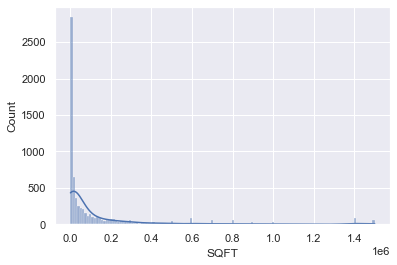

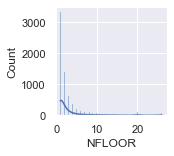

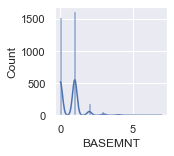

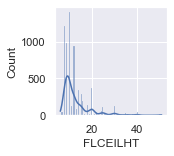

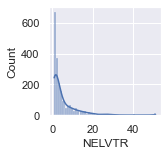

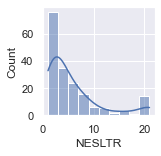

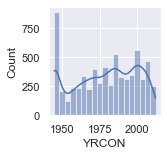

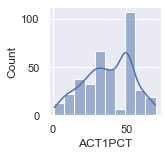

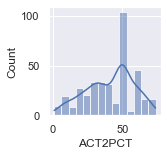

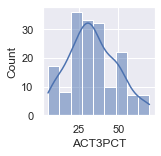

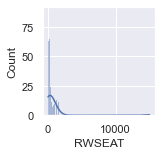

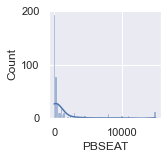

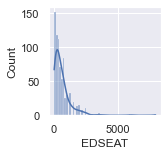

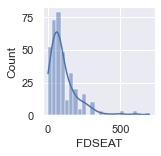

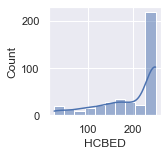

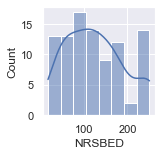

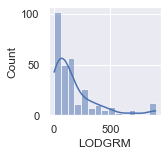

In [18]:
build_hist(df1_numeric_cols)

In [19]:
df1_codebook = create_new_codebook(df_codebook, list(df1.columns))
replace_map1, error_map1 = create_replace_map(df1_codebook, df1, return_errors=True)
print(error_map1)

JSONDecodeError on column BLDSHP
JSONDecodeError on column ACT1
JSONDecodeError on column ACT2
JSONDecodeError on column ACT3
{'BLDSHP': ('BLDSHP', JSONDecodeError("Expecting ',' delimiter: line 1 column 132 (char 131)")), 'ACT1': ('ACT1', JSONDecodeError("Expecting ',' delimiter: line 1 column 60 (char 59)")), 'ACT2': ('ACT2', JSONDecodeError("Expecting ',' delimiter: line 1 column 60 (char 59)")), 'ACT3': ('ACT3', JSONDecodeError("Expecting ',' delimiter: line 1 column 60 (char 59)"))}


In [20]:
df1_filled = df1.replace(to_replace=replace_map1, value=0).fillna(value=0)
df1_filled.sample(5)

,SQFT,NFLOOR,BASEMNT,FLCEILHT,NELVTR,NESLTR,YRCON,ACT1PCT,ACT2PCT,ACT3PCT,...,FACIL,FEDFAC,FACACT,MANIND,PLANT,FACDST,FACDHW,FACDCW,FACELC,BLDPLT
5796,1200,1,0.0,10,0.0,0.0,1945,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5047,16000,2,1.0,25,0.0,0.0,1966,50.0,50.0,0.0,...,1,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1422,3400,2,0.0,10,0.0,0.0,1960,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,2950,1,0.0,8,0.0,0.0,1958,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2931,76000,3,1.0,20,0.0,0.0,1945,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler1 = StandardScaler()
pca1 = PCA()

x1 = df1_filled.to_numpy(dtype=float, copy=True)
x1_scaled = scaler1.fit_transform(x1)
x1_pca = pca1.fit_transform(x1_scaled)

pca1_exp_var = pd.DataFrame(pca1.explained_variance_ratio_,)
pca1_exp_var.T

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
0,0.127743,0.081294,0.068756,0.052494,0.035361,0.032036,0.029407,0.02495,0.023626,0.021471,...,0.001692,0.001569,0.00152,0.00146,0.001276,0.000882,0.000785,0.000495,0.000273,0.000108


Text(0, 0.5, 'cumulative explained variance')

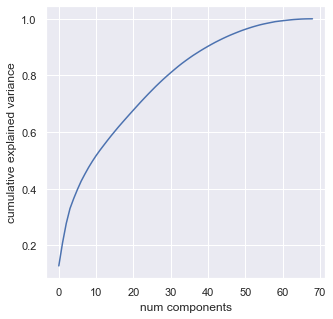

In [22]:
plt.figure(figsize=(5,5))
plt.plot(np.cumsum(pca1.explained_variance_ratio_))
plt.xlabel('num components')
plt.ylabel('cumulative explained variance')

<AxesSubplot:xlabel='0', ylabel='1'>

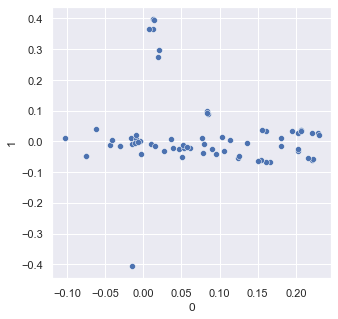

In [23]:
pca_x1_df = pd.DataFrame(pca1.components_)
sns.set(rc = {'figure.figsize':(5,5)})
sns.scatterplot(x=pca_x1_df.T[0], y=pca_x1_df.T[1])

### EDA Category 2

Building Ownership - Not now

In [24]:
df2, df2_numeric_cols, df2_categorical_cols = find_num_cat_cols(category_dfs, 2, num_cols, cat_cols)
print(df2_numeric_cols)
print(df2_categorical_cols)
df2.sample(5)

['NOCC']
['GOVOWN', 'GOVTYP', 'OWNTYPE', 'NOCCAT', 'OWNOCC', 'OWNOPR', 'OWNPPR', 'NWNPPR', 'NWNOPR', 'WHOPPR']


,NOCC,GOVOWN,GOVTYP,OWNTYPE,NOCCAT,OWNOCC,OWNOPR,OWNPPR,NWNPPR,NWNOPR,WHOPPR
5712,1,1,3.0,10,2,1.0,1,1.0,NaN,NaN,NaN
6137,55,1,3.0,10,7,3.0,2,NaN,NaN,2.0,2.0
4922,1,2,NaN,3,2,1.0,1,1.0,NaN,NaN,NaN
6558,29,2,NaN,3,6,3.0,2,NaN,NaN,2.0,1.0
5838,1,2,NaN,5,2,1.0,1,1.0,NaN,NaN,NaN


In [25]:
df2_new_codebook = create_new_codebook(df_codebook, list(df2.columns))
replace_map2, error_map2 = create_replace_map(df2_new_codebook, df2, return_errors=True)

In [26]:
df2_filled = df2.replace(to_replace=replace_map2, value=0).fillna(value=0)
df2_filled.sample(5)

,NOCC,GOVOWN,GOVTYP,OWNTYPE,NOCCAT,OWNOCC,OWNOPR,OWNPPR,NWNPPR,NWNOPR,WHOPPR
3569,2,0,0.0,2,3,1.0,1,1.0,0.0,0.0,0.0
287,1,0,0.0,2,2,1.0,1,1.0,0.0,0.0,0.0
4140,1,0,0.0,2,2,1.0,1,1.0,0.0,0.0,0.0
6127,1,0,0.0,3,2,1.0,1,1.0,0.0,0.0,0.0
1273,6,0,0.0,5,4,2.0,0,0.0,0.0,2.0,1.0


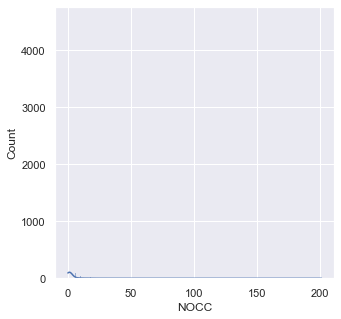

In [27]:
build_hist(df2_numeric_cols)

In [28]:
scaler2 = StandardScaler()
pca2 = PCA()

x2 = df2_filled.to_numpy(dtype=float, copy=True)
x2_scaled = scaler2.fit_transform(x2)
x2_pca = pca2.fit_transform(x2_scaled)

In [29]:
pca2_exp_var = pd.DataFrame(pca2.explained_variance_ratio_,)
pca2_exp_var.T

,0,1,2,3,4,5,6,7,8,9,10
0,0.364221,0.215591,0.172963,0.095911,0.063611,0.048971,0.018074,0.010886,0.006374,0.002238,0.00116


Text(0, 0.5, 'cumulative explained variance')

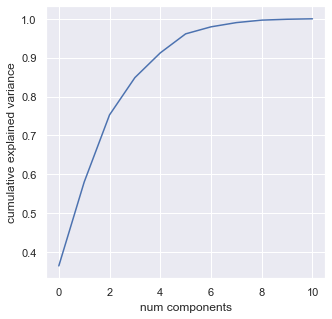

In [30]:
plt.figure(figsize=(5,5))
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('num components')
plt.ylabel('cumulative explained variance')

<AxesSubplot:xlabel='0', ylabel='1'>

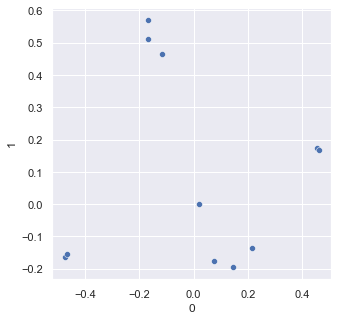

In [31]:
pca_x2_df = pd.DataFrame(pca2.components_)
sns.set(rc = {'figure.figsize':(5,5)})
sns.scatterplot(x=pca_x2_df.T[0], y=pca_x2_df.T[1])

### EDA Category 3

Operations

In [32]:
df3, df3_numeric_cols, df3_categorical_cols = find_num_cat_cols(category_dfs, 3, num_cols, cat_cols)
print(df3_numeric_cols)
print(df3_categorical_cols)
df3.sample(5)

['MONUSE', 'OCCUPYP', 'LODOCCP', 'WKHRS', 'NWKER']
['OPEN24', 'OPNMF', 'OPNWE', 'WKHRSC', 'NWKERC']


,MONUSE,OCCUPYP,LODOCCP,WKHRS,NWKER,OPEN24,OPNMF,OPNWE,WKHRSC,NWKERC
1482,12,NaN,NaN,168,498,1,1,1,7,8
6039,12,NaN,NaN,45,6,2,1,2,3,3
6176,12,NaN,NaN,24,1,2,2,1,2,2
2256,12,NaN,NaN,45,8,2,1,2,3,3
1803,12,84.0,NaN,168,625,1,1,1,7,9


In [33]:
df3_new_codebook = create_new_codebook(df_codebook, list(df3.columns))
replace_map3, error_map3 = create_replace_map(df3_new_codebook, df3, return_errors=True)

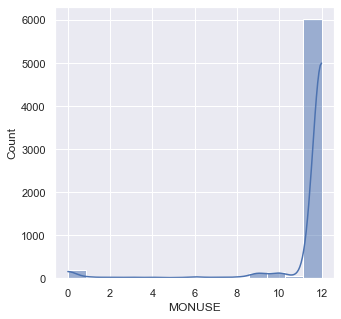

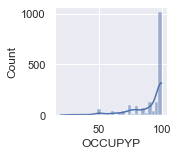

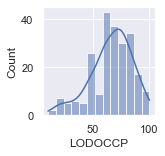

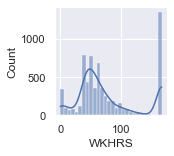

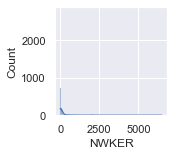

In [34]:
build_hist(df3_numeric_cols)

In [35]:
df3_filled = df3.replace(to_replace=replace_map3, value=0).fillna(value=0)
df3_filled.sample(5)

,MONUSE,OCCUPYP,LODOCCP,WKHRS,NWKER,OPEN24,OPNMF,OPNWE,WKHRSC,NWKERC
5793,0,0.0,0.0,0,0,0,3,0,1,1
3853,12,100.0,0.0,45,1519,0,1,0,3,10
322,12,0.0,70.0,168,250,1,1,1,7,8
787,12,0.0,0.0,48,2,0,1,1,3,2
188,12,0.0,0.0,40,8,0,1,0,3,3


In [36]:
scaler3 = StandardScaler()
pca3 = PCA()

x3 = df3_filled.to_numpy(dtype=float, copy=True)
x3_scaled = scaler3.fit_transform(x3)
x3_pca = pca3.fit_transform(x3_scaled)

In [37]:
pca3_exp_var = pd.DataFrame(pca3.explained_variance_ratio_,)
pca3_exp_var.T

,0,1,2,3,4,5,6,7,8,9
0,0.389971,0.167116,0.128317,0.090151,0.071149,0.063742,0.041669,0.03175,0.014635,0.001501


Text(0, 0.5, 'cumulative explained variance')

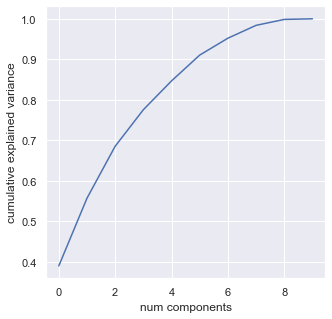

In [38]:
plt.figure(figsize=(5,5))
plt.plot(np.cumsum(pca3.explained_variance_ratio_))
plt.xlabel('num components')
plt.ylabel('cumulative explained variance')

<AxesSubplot:xlabel='0', ylabel='1'>

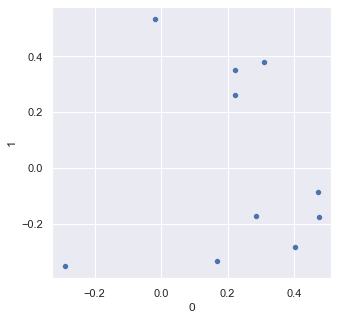

In [39]:
pca_x3_df = pd.DataFrame(pca3.components_)
sns.set(rc = {'figure.figsize':(5,5)})
sns.scatterplot(x=pca_x3_df.T[0], y=pca_x3_df.T[1])

### EDA Category 4

Energy Source / Purpose

In [40]:
df4, df4_numeric_cols, df4_categorical_cols = find_num_cat_cols(category_dfs, 4, num_cols, cat_cols)
print(df4_numeric_cols)
print(df4_categorical_cols)
df4.sample(5)

['HEATP', 'FURNP', 'PKGHP', 'BOILP', 'STHWP', 'HTPHP', 'SLFCNP', 'OTHTP', 'COOLP', 'RCACP', 'PKGCP', 'CHILP', 'CHWTP', 'HTPCP', 'ACWNWP', 'EVAPP', 'OTCLP', 'BOOSTWT', 'ELLUPCT', 'WOEXP']
['HT1', 'HT2', 'COOL', 'WATR', 'COOK', 'MANU', 'CAPGEN', 'GENR', 'ANYEGY', 'ELUSED', 'NGUSED', 'FKUSED', 'FKTYPE', 'PRUSED', 'STUSED', 'HWUSED', 'CWUSED', 'WOUSED', 'COUSED', 'SOUSED', 'OTUSED', 'ELHT1', 'NGHT1', 'FKHT1', 'PRHT1', 'STHT1', 'HWHT1', 'WOHT1', 'COHT1', 'SOHT1', 'OTHT1', 'ELHT2', 'NGHT2', 'FKHT2', 'PRHT2', 'STHT2', 'HWHT2', 'WOHT2', 'COHT2', 'SOHT2', 'OTHT2', 'HTLS50', 'FURNAC', 'PKGHT', 'BOILER', 'STHW', 'HTPMPH', 'SLFCON', 'OTHTEQ', 'MAINHT', 'NWMNHT', 'PKGHTTYP', 'PKGFURN', 'PKGHTP', 'PKGCOIL', 'PKGPIU', 'PKGDUCT', 'BLRRAD', 'BLRFNCL', 'BLRINDC', 'BLRLOOP', 'BLRAIR', 'BLRPKG', 'BLRDUCT', 'DHRAD', 'DHFNCL', 'DHINDC', 'DHLOOP', 'DHAIR', 'DHPKG', 'DHDUCT', 'HPHPKG', 'HPHSPLT', 'HPHROOM', 'HPHMINI', 'HPHVRF', 'HPHAIR', 'HPHGRD', 'HPHDUAL', 'HPHWTR', 'HPHBKUP', 'SHRDNT', 'SHBBRD', 'SHPORT', 

,HEATP,FURNP,PKGHP,BOILP,STHWP,HTPHP,SLFCNP,OTHTP,COOLP,RCACP,...,ELLOCUT,ELNONLU,ELOTSRC,ELCPLT,NGSRC,PRAMTC,PRUNIT,WOAMT,WOSRC,WOEXPC
147,100.0,NaN,100.0,NaN,NaN,NaN,NaN,NaN,100.0,NaN,...,9.0,9.0,9.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
5880,100.0,100.0,95.0,NaN,NaN,NaN,5.0,NaN,98.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3513,100.0,NaN,NaN,NaN,NaN,NaN,100.0,NaN,100.0,NaN,...,1.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2855,80.0,NaN,75.0,NaN,NaN,25.0,NaN,NaN,80.0,NaN,...,1.0,2.0,1.0,2.0,3.0,1.0,1.0,NaN,NaN,NaN
3248,100.0,NaN,20.0,80.0,NaN,NaN,1.0,NaN,15.0,NaN,...,1.0,2.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN


In [41]:
df4_new_codebook = create_new_codebook(df_codebook, list(df4.columns))
replace_map4, error_map4 = create_replace_map(df4_new_codebook, df4, return_errors=True)

JSONDecodeError on column MAINCL
JSONDecodeError on column WTHTEQ


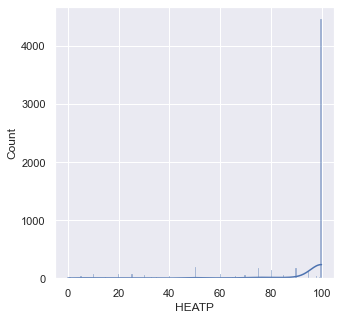

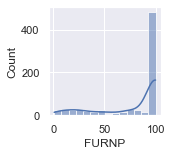

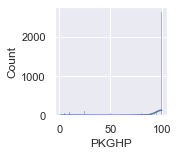

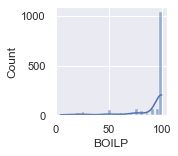

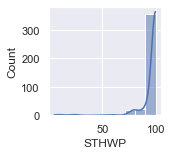

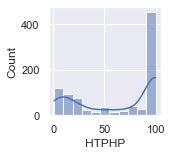

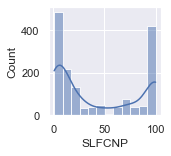

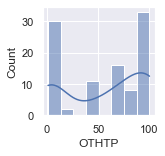

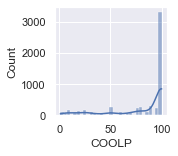

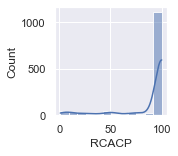

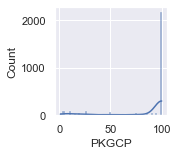

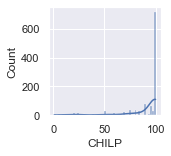

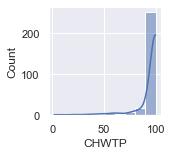

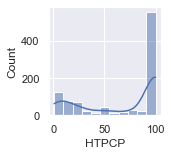

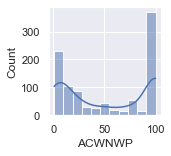

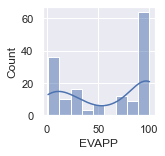

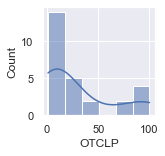

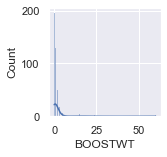

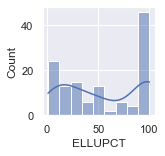

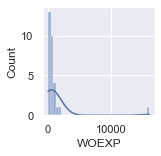

In [42]:
build_hist(df4_numeric_cols)

In [43]:
df4_filled = df4.replace(to_replace=replace_map4, value=0).fillna(value=0)
df4_filled.sample(5)

,HEATP,FURNP,PKGHP,BOILP,STHWP,HTPHP,SLFCNP,OTHTP,COOLP,RCACP,...,ELLOCUT,ELNONLU,ELOTSRC,ELCPLT,NGSRC,PRAMTC,PRUNIT,WOAMT,WOSRC,WOEXPC
1922,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6271,100.0,0.0,100.0,44.0,0.0,0.0,0.0,0.0,100.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1729,90.0,0.0,0.0,95.0,0.0,10.0,0.0,0.0,95.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5313,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6436,100.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,33.0,0.0,...,1.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0


In [44]:
scaler4 = StandardScaler()
pca4 = PCA()

x4 = df4_filled.to_numpy(dtype=float, copy=True)
x4_scaled = scaler4.fit_transform(x4)
x4_pca = pca4.fit_transform(x4_scaled)

In [45]:
pca4_exp_var = pd.DataFrame(pca4.explained_variance_ratio_,)
pca4_exp_var.T

,0,1,2,3,4,5,6,7,8,9,...,234,235,236,237,238,239,240,241,242,243
0,0.071419,0.053054,0.037087,0.033667,0.023491,0.020146,0.018716,0.018282,0.017298,0.015946,...,3.052651e-34,3.052651e-34,3.052651e-34,3.052651e-34,3.052651e-34,3.052651e-34,3.052651e-34,3.052651e-34,3.052651e-34,5.868558e-35


Text(0, 0.5, 'cumulative explained variance')

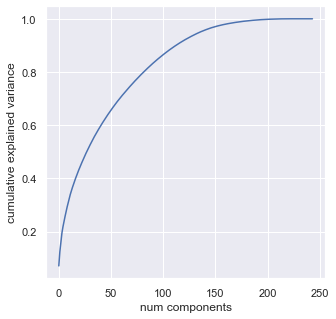

In [46]:
plt.figure(figsize=(5,5))
plt.plot(np.cumsum(pca4.explained_variance_ratio_))
plt.xlabel('num components')
plt.ylabel('cumulative explained variance')

<AxesSubplot:xlabel='0', ylabel='1'>

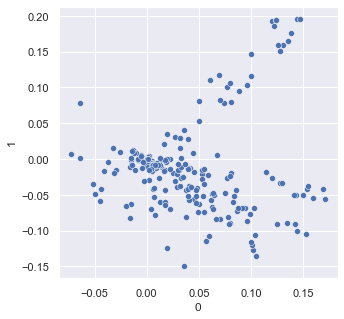

In [47]:
pca_x4_df = pd.DataFrame(pca4.components_)
sns.set(rc = {'figure.figsize':(5,5)})
sns.scatterplot(x=pca_x4_df.T[0], y=pca_x4_df.T[1])

### EDA Category 5

Energy Management

In [48]:
df5, df5_numeric_cols, df5_categorical_cols = find_num_cat_cols(category_dfs, 5, num_cols, cat_cols)
print(df5_numeric_cols)
print(df5_categorical_cols)
df5.sample(5)

[]
['AMIMETER', 'ENRGYPLN']


,AMIMETER,ENRGYPLN
1662,2.0,2.0
2981,1.0,2.0
4104,2.0,2.0
4583,2.0,2.0
386,2.0,2.0


In [49]:
df5_new_codebook = create_new_codebook(df_codebook, list(df5.columns))
replace_map5, error_map5 = create_replace_map(df5_new_codebook, df5, return_errors=True)

In [50]:
build_hist(df5_numeric_cols)

In [51]:
df5_filled = df5.replace(to_replace=replace_map5, value=0).fillna(value=0)
df5_filled.sample(5)

,AMIMETER,ENRGYPLN
4745,1.0,0.0
1836,1.0,1.0
1034,0.0,0.0
6584,0.0,0.0
4634,0.0,0.0


In [52]:
scaler5 = StandardScaler()
pca5 = PCA()

x5 = df5_filled.to_numpy(dtype=float, copy=True)
x5_scaled = scaler5.fit_transform(x5)
x5_pca = pca5.fit_transform(x5_scaled)

In [53]:
pca5_exp_var = pd.DataFrame(pca5.explained_variance_ratio_,)
pca5_exp_var.T

,0,1
0,0.533378,0.466622


Text(0, 0.5, 'cumulative explained variance')

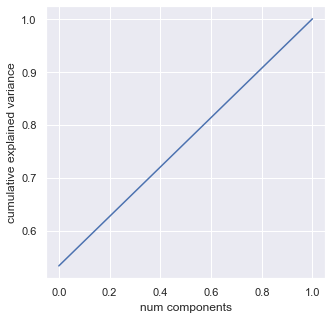

In [54]:
plt.figure(figsize=(5,5))
plt.plot(np.cumsum(pca5.explained_variance_ratio_))
plt.xlabel('num components')
plt.ylabel('cumulative explained variance')

<AxesSubplot:xlabel='0', ylabel='1'>

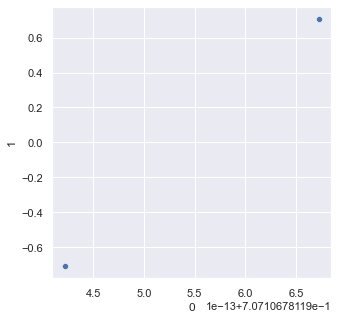

In [55]:
pca_x5_df = pd.DataFrame(pca5.components_)
sns.set(rc = {'figure.figsize':(5,5)})
sns.scatterplot(x=pca_x5_df.T[0], y=pca_x5_df.T[1])

### EDA Category 6

Service Industry Characteristics - Not right now

In [56]:
df6, df6_numeric_cols, df6_categorical_cols = find_num_cat_cols(category_dfs, 6, num_cols, cat_cols)
print(df6_numeric_cols)
print(df6_categorical_cols)
df6.sample(5)

['CONFSPP', 'XRAYN', 'RFGRSN', 'RFGCOMPN', 'RFGWIN', 'RFGOPN', 'RFGCLN', 'RFGVNN', 'RFGICN', 'RFGSTP', 'PCTERMN', 'LAPTPN', 'PRNTRN', 'SERVERN', 'TVVIDEON', 'RGSTRN', 'COPIERN']
['SNACK', 'FASTFD', 'CAF', 'FDPREP', 'KITCHN', 'BREAKRM', 'OTFDRM', 'HWTRM', 'LAUNDR', 'CONFSP', 'MEDEQP', 'CTSCAN', 'MRI', 'LINACC', 'OUTSURG', 'LABEQP', 'MCHEQP', 'POOL', 'HTPOOL', 'POOLSRC', 'STRLZR', 'RFGEQP', 'RFGRES', 'RFGCOMP', 'RFGWI', 'RFGOP', 'RFGCL', 'RFGVEN', 'RFGICE', 'RFGSTO', 'WHRECOV', 'WHHT2', 'WHWT', 'WHOT', 'PCTERM', 'PCTRMC', 'MLTMON', 'MLTMNC', 'FLATC', 'LAPTPC', 'PRNTYP', 'SERVER', 'SERVERC', 'DATACNTR', 'DCNTRSFC', 'TRNGRM', 'STDNRM', 'WBOARDS', 'TVVIDEO', 'RGSTR', 'COPIER', 'FAX']


,CONFSPP,XRAYN,RFGRSN,RFGCOMPN,RFGWIN,RFGOPN,RFGCLN,RFGVNN,RFGICN,RFGSTP,...,SERVERC,DATACNTR,DCNTRSFC,TRNGRM,STDNRM,WBOARDS,TVVIDEO,RGSTR,COPIER,FAX
3872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,1.0,2.0,NaN,2.0,2.0,NaN,1.0,1.0,1.0,1.0
293,NaN,2.0,7.0,12.0,2.0,NaN,NaN,4.0,6.0,NaN,...,3.0,1.0,1.0,2.0,2.0,NaN,1.0,1.0,1.0,1.0
2173,NaN,NaN,2.0,NaN,1.0,NaN,NaN,1.0,1.0,NaN,...,1.0,2.0,NaN,2.0,2.0,NaN,2.0,1.0,2.0,1.0
3137,NaN,NaN,6.0,NaN,NaN,NaN,NaN,6.0,4.0,NaN,...,1.0,2.0,NaN,2.0,2.0,NaN,1.0,2.0,2.0,2.0
5591,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0


In [57]:
df6_new_codebook = create_new_codebook(df_codebook, list(df6.columns))
replace_map6, error_map6 = create_replace_map(df6_new_codebook, df6, return_errors=True)

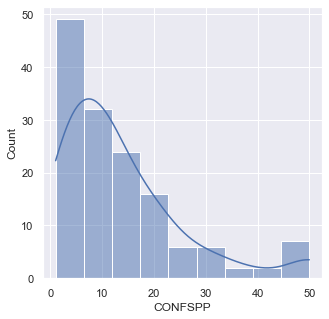

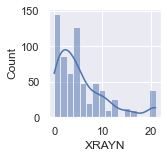

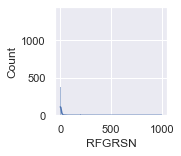

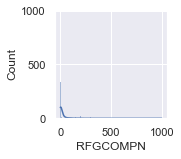

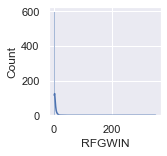

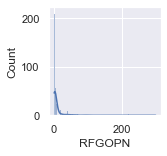

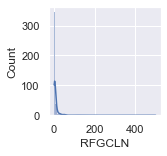

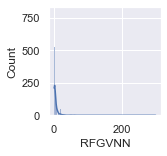

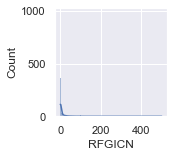

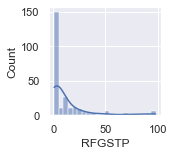

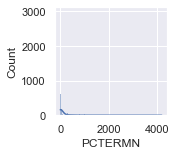

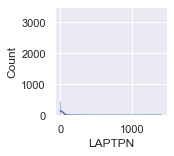

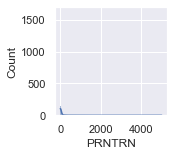

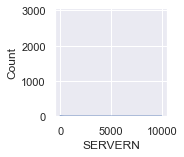

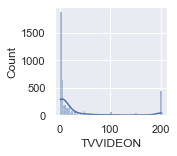

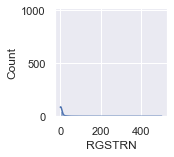

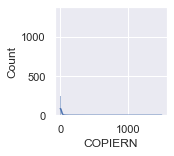

In [58]:
build_hist(df6_numeric_cols)

In [59]:
df6_filled = df6.replace(to_replace=replace_map6, value=0).fillna(value=0)
df6_filled.sample(5)

,CONFSPP,XRAYN,RFGRSN,RFGCOMPN,RFGWIN,RFGOPN,RFGCLN,RFGVNN,RFGICN,RFGSTP,...,SERVERC,DATACNTR,DCNTRSFC,TRNGRM,STDNRM,WBOARDS,TVVIDEO,RGSTR,COPIER,FAX
1945,0.0,0.0,0.0,40.0,0.0,0.0,0.0,7.0,0.0,0.0,...,5.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6108,0.0,10.0,100.0,100.0,3.0,3.0,12.0,10.0,30.0,1.0,...,6.0,1.0,3.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
4943,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2535,0.0,0.0,1.0,2.0,2.0,0.0,7.0,1.0,3.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [60]:
scaler6 = StandardScaler()
pca6 = PCA()

x6 = df6_filled.to_numpy(dtype=float, copy=True)
x6_scaled = scaler6.fit_transform(x6)
x6_pca = pca6.fit_transform(x6_scaled)

In [61]:
pca6_exp_var = pd.DataFrame(pca6.explained_variance_ratio_,)
pca6_exp_var.T

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
0,0.213333,0.061671,0.055628,0.050079,0.036262,0.03024,0.028071,0.023072,0.022491,0.021402,...,0.002931,0.002711,0.002251,0.002148,0.001679,0.00151,0.001255,0.001107,0.000694,0.000165


Text(0, 0.5, 'cumulative explained variance')

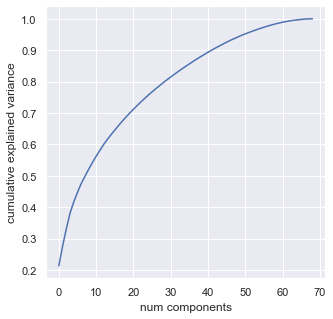

In [62]:
plt.figure(figsize=(5,5))
plt.plot(np.cumsum(pca6.explained_variance_ratio_))
plt.xlabel('num components')
plt.ylabel('cumulative explained variance')

<AxesSubplot:xlabel='0', ylabel='1'>

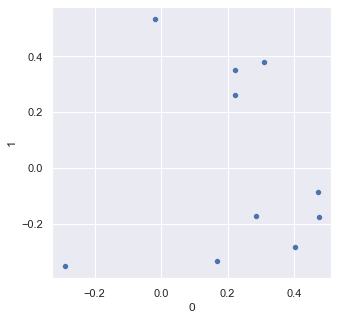

In [63]:
pca_x6_df = pd.DataFrame(pca3.components_)
sns.set(rc = {'figure.figsize':(5,5)})
sns.scatterplot(x=pca_x6_df.T[0], y=pca_x6_df.T[1])

### Category 7

Lighting

In [64]:
df7, df7_numeric_cols, df7_categorical_cols = find_num_cat_cols(category_dfs, 7, num_cols, cat_cols)
print(df7_numeric_cols)
print(df7_categorical_cols)
df7.sample(5)

['LTOHRP', 'LTNHRP', 'FLUORP', 'CFLRP', 'BULBP', 'HALOP', 'HIDP', 'LEDP', 'OTLTP', 'DAYLTP']
['LOHRPC', 'LTNR24', 'LNHRPC', 'RDLTNF', 'FLUOR', 'CFLR', 'BULB', 'HALO', 'HID', 'LED', 'OTLT', 'EMCSLT', 'SCHED', 'OCSN', 'DIM', 'DAYHARV', 'TRIM', 'PLGCTRL', 'DRLGHT', 'LTEXPC', 'PKLT', 'WINTYP', 'TINT', 'REFL', 'AWN', 'SKYLT']


,LTOHRP,LTNHRP,FLUORP,CFLRP,BULBP,HALOP,HIDP,LEDP,OTLTP,DAYLTP,...,TRIM,PLGCTRL,DRLGHT,LTEXPC,PKLT,WINTYP,TINT,REFL,AWN,SKYLT
3385,20.0,0.0,95.0,NaN,5.0,NaN,NaN,NaN,NaN,10.0,...,2.0,2.0,2.0,1.0,2.0,1,2.0,2.0,2.0,2.0
5824,100.0,25.0,65.0,15.0,2.0,13.0,20.0,4.0,NaN,0.0,...,2.0,2.0,2.0,2.0,1.0,2,1.0,2.0,2.0,2.0
2040,90.0,5.0,90.0,1.0,NaN,5.0,4.0,NaN,NaN,5.0,...,2.0,2.0,2.0,1.0,1.0,3,2.0,2.0,2.0,1.0
3719,90.0,10.0,95.0,40.0,10.0,5.0,2.0,5.0,NaN,0.0,...,2.0,2.0,2.0,1.0,1.0,1,1.0,1.0,2.0,2.0
6554,100.0,25.0,80.0,3.0,1.0,NaN,1.0,20.0,NaN,0.0,...,2.0,2.0,2.0,2.0,1.0,3,1.0,2.0,2.0,2.0


In [65]:
df7_new_codebook = create_new_codebook(df_codebook, list(df7.columns))
replace_map7, error_map7 = create_replace_map(df7_new_codebook, df7, return_errors=True)

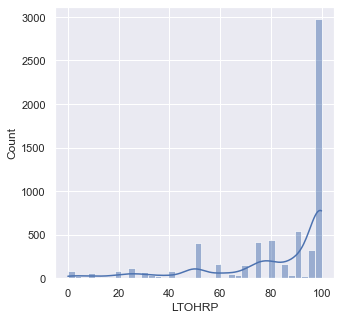

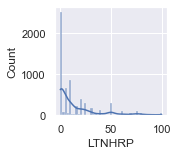

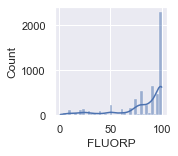

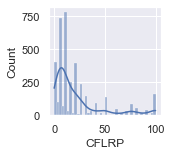

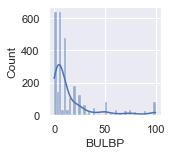

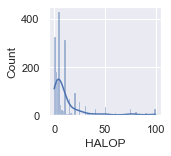

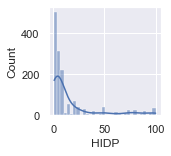

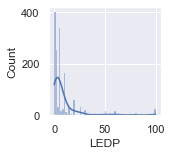

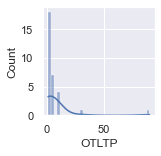

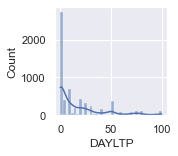

In [66]:
build_hist(df7_numeric_cols)

In [67]:
df7_filled = df7.replace(to_replace=replace_map7, value=0).fillna(value=0)
df7_filled.sample(5)

,LTOHRP,LTNHRP,FLUORP,CFLRP,BULBP,HALOP,HIDP,LEDP,OTLTP,DAYLTP,...,TRIM,PLGCTRL,DRLGHT,LTEXPC,PKLT,WINTYP,TINT,REFL,AWN,SKYLT
1035,85.0,50.0,60.0,30.0,0.0,0.0,0.0,10.0,0.0,20.0,...,0.0,0.0,0.0,4.0,1.0,3,1.0,0.0,0.0,0.0
5078,100.0,2.0,10.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,1,0.0,0.0,1.0,1.0
446,70.0,0.0,90.0,30.0,0.0,0.0,0.0,0.0,0.0,20.0,...,0.0,0.0,0.0,3.0,1.0,2,1.0,0.0,0.0,0.0
1778,90.0,40.0,80.0,5.0,10.0,5.0,0.0,0.0,0.0,10.0,...,0.0,0.0,0.0,1.0,1.0,3,1.0,0.0,1.0,1.0
6081,100.0,0.0,90.0,0.0,0.0,0.0,10.0,1.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,3,1.0,0.0,0.0,0.0


In [68]:
scaler7 = StandardScaler()
pca7 = PCA()

x7 = df7_filled.to_numpy(dtype=float, copy=True)
x7_scaled = scaler7.fit_transform(x7)
x7_pca = pca7.fit_transform(x7_scaled)

In [69]:
pca7_exp_var = pd.DataFrame(pca7.explained_variance_ratio_,)
pca7_exp_var.T

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.139365,0.076375,0.052149,0.045038,0.040691,0.038687,0.035816,0.034869,0.033939,0.032279,...,0.016066,0.014342,0.012328,0.010078,0.009765,0.009567,0.009149,0.00862,0.004144,0.001819


Text(0, 0.5, 'cumulative explained variance')

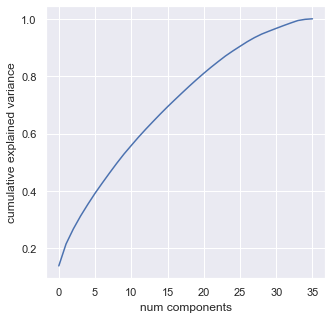

In [70]:
plt.figure(figsize=(5,5))
plt.plot(np.cumsum(pca7.explained_variance_ratio_))
plt.xlabel('num components')
plt.ylabel('cumulative explained variance')

<AxesSubplot:xlabel='0', ylabel='1'>

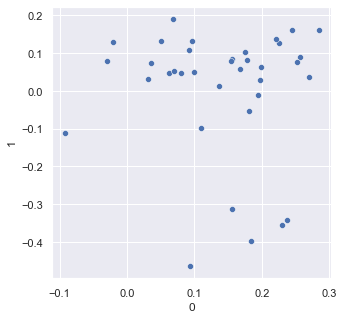

In [71]:
pca_x7_df = pd.DataFrame(pca7.components_)
sns.set(rc = {'figure.figsize':(5,5)})
sns.scatterplot(x=pca_x7_df.T[0], y=pca_x7_df.T[1])

### Category 10

Energy Expenses and Consumption

In [72]:
df10, df10_numeric_cols, df10_categorical_cols = find_num_cat_cols(category_dfs, 10, num_cols, cat_cols)
print(df10_numeric_cols)
print(df10_categorical_cols)
df10.sample(5)

['HDD65', 'CDD65', 'MFHTBTU', 'MFCLBTU', 'MFVNBTU', 'MFWTBTU', 'MFLTBTU', 'MFCKBTU', 'MFRFBTU', 'MFOFBTU', 'MFPCBTU', 'MFOTBTU', 'ELHTBTU', 'ELCLBTU', 'ELVNBTU', 'ELWTBTU', 'ELLTBTU', 'ELCKBTU', 'ELRFBTU', 'ELOFBTU', 'ELPCBTU', 'ELOTBTU', 'NGHTBTU', 'NGCLBTU', 'NGWTBTU', 'NGCKBTU', 'NGOTBTU', 'FKHTBTU', 'FKCLBTU', 'FKWTBTU', 'FKCKBTU', 'FKOTBTU', 'DHHTBTU', 'DHCLBTU', 'DHWTBTU', 'DHCKBTU', 'DHOTBTU']
['MFUSED', 'DHUSED', 'DHHT1', 'DHHT2', 'DHCOOL', 'DHCOOK', 'DHWATR', 'DHMANU', 'DHOTH', 'PUBCLIM']


,HDD65,CDD65,MFHTBTU,MFCLBTU,MFVNBTU,MFWTBTU,MFLTBTU,MFCKBTU,MFRFBTU,MFOFBTU,...,MFUSED,DHUSED,DHHT1,DHHT2,DHCOOL,DHCOOK,DHWATR,DHMANU,DHOTH,PUBCLIM
2858,4021,1430,482886.0,800133.0,221996.0,29864.0,453851.0,85266.0,0.0,21867.0,...,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4150,5965,1336,141772.0,6626.0,7320.0,9518.0,9722.0,0.0,1929.0,4180.0,...,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5822,5125,693,80410.0,15737.0,68374.0,58558.0,186548.0,114733.0,24028.0,109965.0,...,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
460,4566,1138,1734850.0,50896.0,45918.0,82957.0,233163.0,0.0,4204.0,5939.0,...,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5548,5113,743,1479000.0,0.0,763027.0,49405.0,292550.0,0.0,11324.0,38930.0,...,1,1,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1


In [73]:
df10_new_codebook = create_new_codebook(df_codebook, list(df10.columns))
replace_map10, error_map10 = create_replace_map(df10_new_codebook, df10, return_errors=True)

C:\Users\evaze\AppData\Local\Temp/ipykernel_21512/2053539771.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figname)


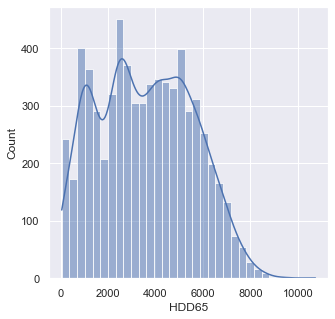

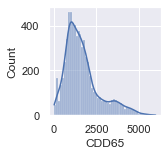

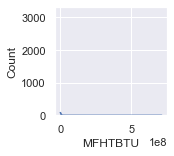

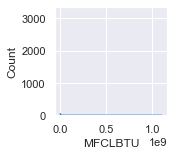

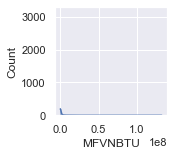

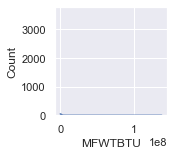

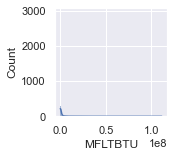

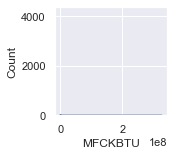

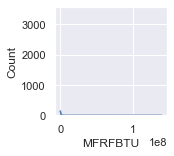

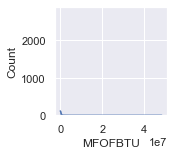

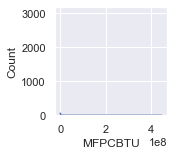

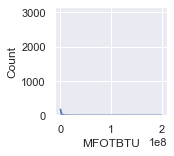

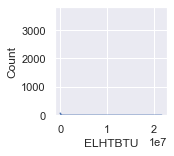

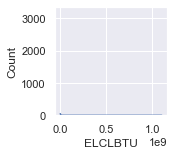

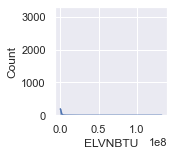

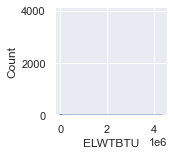

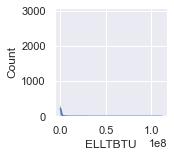

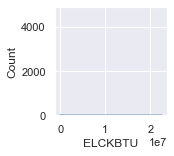

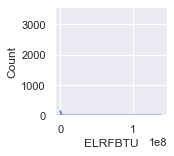

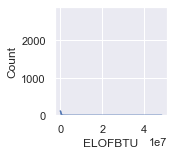

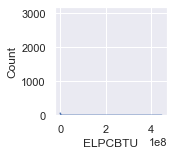

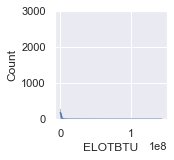

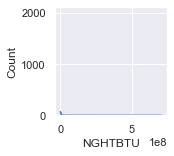

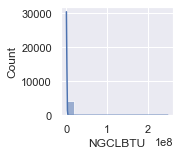

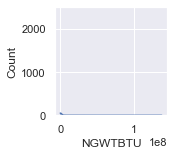

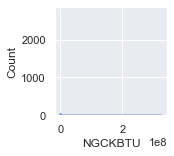

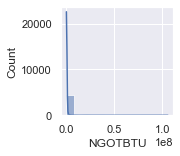

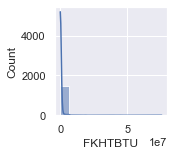

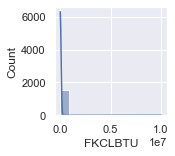

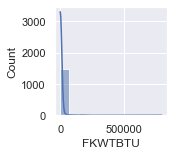

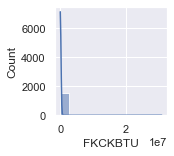

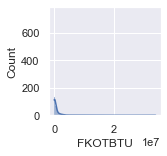

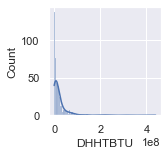

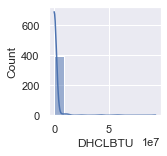

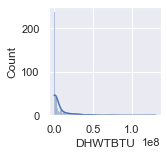

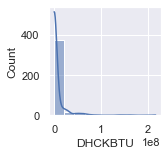

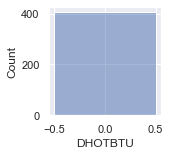

In [74]:
build_hist(df10_numeric_cols)

In [75]:
df10_filled = df10.replace(to_replace=replace_map10, value=0).fillna(value=0)
df10_filled.sample(5)

,HDD65,CDD65,MFHTBTU,MFCLBTU,MFVNBTU,MFWTBTU,MFLTBTU,MFCKBTU,MFRFBTU,MFOFBTU,...,MFUSED,DHUSED,DHHT1,DHHT2,DHCOOL,DHCOOK,DHWATR,DHMANU,DHOTH,PUBCLIM
3288,5615,996,91174.0,0.0,9281.0,44.0,35210.0,0.0,0.0,4278.0,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4701,3544,1754,181526.0,504673.0,116264.0,86285.0,166380.0,0.0,0.0,14823.0,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
6257,4919,602,12224.0,3347.0,8451.0,1296.0,10691.0,0.0,174537.0,1782.0,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
272,6194,1052,483631.0,156750.0,146942.0,57672.0,176516.0,0.0,5377.0,85514.0,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5680,4684,1262,122283.0,23407.0,3269.0,354.0,11757.0,0.0,7008.0,919.0,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [76]:
scaler10 = StandardScaler()
pca10 = PCA()

x10 = df10_filled.to_numpy(dtype=float, copy=True)
x10_scaled = scaler10.fit_transform(x10)
x10_pca = pca10.fit_transform(x10_scaled)

In [77]:
pca10_exp_var = pd.DataFrame(pca10.explained_variance_ratio_,)
pca10_exp_var.T

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,0.293256,0.082893,0.051142,0.049872,0.048599,0.041385,0.036986,0.033594,0.033233,0.029744,...,2.117972e-33,2.117972e-33,2.117972e-33,2.117972e-33,2.117972e-33,2.117972e-33,2.117972e-33,1.898309e-33,7.143511e-34,6.797192e-34


Text(0, 0.5, 'cumulative explained variance')

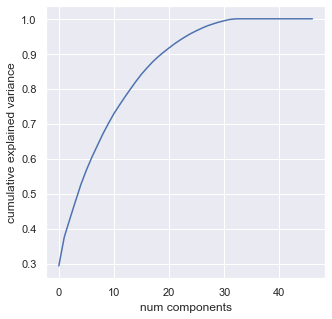

In [78]:
plt.figure(figsize=(5,5))
plt.plot(np.cumsum(pca10.explained_variance_ratio_))
plt.xlabel('num components')
plt.ylabel('cumulative explained variance')

<AxesSubplot:xlabel='0', ylabel='1'>

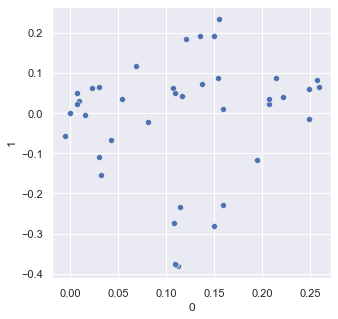

In [79]:
pca_x10_df = pd.DataFrame(pca10.components_)
sns.set(rc = {'figure.figsize':(5,5)})
sns.scatterplot(x=pca_x10_df.T[0], y=pca_x10_df.T[1])